# 本程序及代码是在人工智能工具 ChatGPT (GPT-5，OpenAI，2025年3月) 辅助下完成的


In [ ]:
import warnings, re, os
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

try:
    from imblearn.over_sampling import RandomOverSampler
    HAS_IMBLEARN = True
except Exception:
    HAS_IMBLEARN = False

import matplotlib.pyplot as plt
print("HAS_LGBM =", HAS_LGBM, "| HAS_IMBLEARN =", HAS_IMBLEARN)


HAS_LGBM = True | HAS_IMBLEARN = True


In [ ]:
FEAT_PARQUET = Path("../第1问/2features/features.parquet")  # 请按你的路径调整
OUT_DIR = Path("../第2问/3models"); OUT_DIR.mkdir(parents=True, exist_ok=True)
print("工作目录:", os.getcwd())


工作目录: /home/sues03/shumo/第2问


In [ ]:
def add_rpm_normalized_features(df, feat_cols):
    df2 = df.copy()
    freq_like = ["freq_peak", "spec_centroid", "freq_std", "spec_rolloff95", "rms_freq"]
    env_cols = ["bpfo_E", "bpfi_E", "bsf_E", "ftf_E"]

    fr = (df2["rpm"].astype(float) / 60.0).replace([np.inf, -np.inf], np.nan)
    for c in freq_like:
        if c in df2.columns:
            df2[c + "_order"] = df2[c] / fr

    has_env = [c for c in env_cols if c in df2.columns]
    if has_env:
        total = df2[has_env].sum(axis=1) + 1e-12
        for c in has_env:
            df2[c + "_ratio"] = df2[c] / total

    new_cols = [c for c in df2.columns if c not in df.columns]
    return df2, feat_cols + new_cols

def group_from_segfile(p):
    name = Path(p).stem
    return re.sub(r"_seg\\d+$", "", name)

def plot_confusion_mean(cm_mean, labels, title, save_path):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(cm_mean, aspect="auto")
    ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, f"{cm_mean[i, j]:.0f}", ha="center", va="center")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()


In [ ]:
if not FEAT_PARQUET.exists():
    print("未找到", FEAT_PARQUET)
    print("当前目录可见：", os.listdir())
    raise FileNotFoundError("请修改 FEAT_PARQUET 为你的 features.parquet 实际路径")

df = pd.read_parquet(FEAT_PARQUET)
meta_cols = ["seg_file","label","load","rpm","size_code","clock_pos"]
for c in meta_cols:
    if c not in df.columns:
        raise ValueError(f"缺少必须列: {c}")

feat_cols = [c for c in df.columns if c not in meta_cols]
df.shape, len(feat_cols)


((16423, 36), 30)

In [ ]:

df, feat_cols = add_rpm_normalized_features(df, feat_cols)
print("特征数（含派生）：", len(feat_cols))


特征数（含派生）： 39


In [ ]:

labels = df["label"].astype(str)
cls_cnt = Counter(labels)
avg_n = np.mean(list(cls_cnt.values()))
class_weight = {c: avg_n / n for c, n in cls_cnt.items()}
sample_weight_all = labels.map(class_weight).astype(float).values

groups = df["seg_file"].apply(group_from_segfile)
X = df[feat_cols].values
y = labels.values

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
print("类别统计：", cls_cnt)


类别统计： Counter({'OR': 7640, 'B': 4171, 'IR': 4162, 'N': 450})


In [ ]:

def run_one_model(name, model, oversample=False):
    accs, f1s, cms = [], [], []
    label_order = sorted(cls_cnt.keys())

    if oversample:
        try:
            from imblearn.over_sampling import RandomOverSampler
            oversampler = RandomOverSampler(sampling_strategy="not minority", random_state=42)
        except Exception:
            print("[WARN] imblearn 未安装，过采样将被忽略。")
            oversampler = None
    else:
        oversampler = None

    for fold, (tr, te) in enumerate(cv.split(X, y, groups=groups), 1):
        X_tr, y_tr = X[tr], y[tr]
        X_te, y_te = X[te], y[te]
        sw_tr = sample_weight_all[tr]

        if oversampler is not None:
            X_tr, y_tr = oversampler.fit_resample(X_tr, y_tr)
            sw_tr = np.ones(len(y_tr), dtype=float)

        fit_kwargs = {}
        if 'LGBMClassifier' in str(type(model)):
            model.set_params(class_weight=None)
            fit_kwargs["sample_weight"] = sw_tr

        model.fit(X_tr, y_tr, **fit_kwargs)
        y_pred = model.predict(X_te)
        accs.append(accuracy_score(y_te, y_pred))
        f1s.append(f1_score(y_te, y_pred, average="macro"))
        cms.append(confusion_matrix(y_te, y_pred, labels=label_order))
        print(f"Fold {fold}: acc={accs[-1]:.4f}, macroF1={f1s[-1]:.4f}")

    acc_mean, f1_mean = float(np.mean(accs)), float(np.mean(f1s))
    cm_mean = np.mean(np.stack(cms, axis=0), axis=0)
    plot_confusion_mean(cm_mean, label_order, f"{name} - Mean Confusion Matrix (5-fold)", OUT_DIR / f"{name}_cm.png")
    print(f"[{name}] CV-mean acc={acc_mean:.4f} | macroF1={f1_mean:.4f}")
    return name, acc_mean, f1_mean


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6852
[LightGBM] [Info] Number of data points in the train set: 13138, number of used features: 28
[LightGBM] [Info] Start training from score -1.386204
[LightGBM] [Info] Start training from score -1.386445
[LightGBM] [Info] Start training from score -1.386264
[LightGBM] [Info] Start training from score -1.386264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

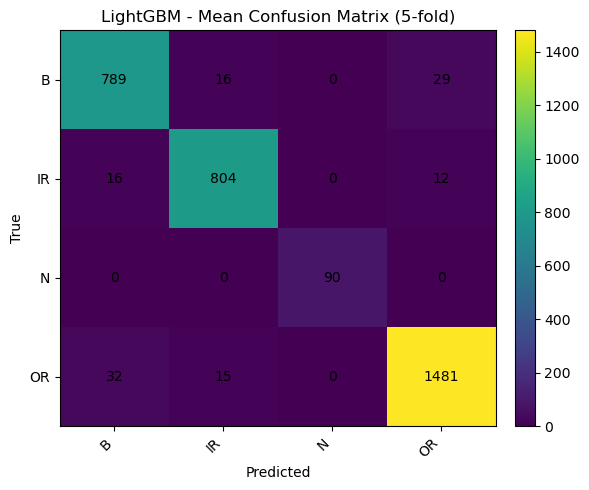

[LightGBM] CV-mean acc=0.9632 | macroF1=0.9698
Fold 1: acc=0.9528, macroF1=0.9612
Fold 2: acc=0.9437, macroF1=0.9527
Fold 3: acc=0.9501, macroF1=0.9581
Fold 4: acc=0.9415, macroF1=0.9494
Fold 5: acc=0.9397, macroF1=0.9507


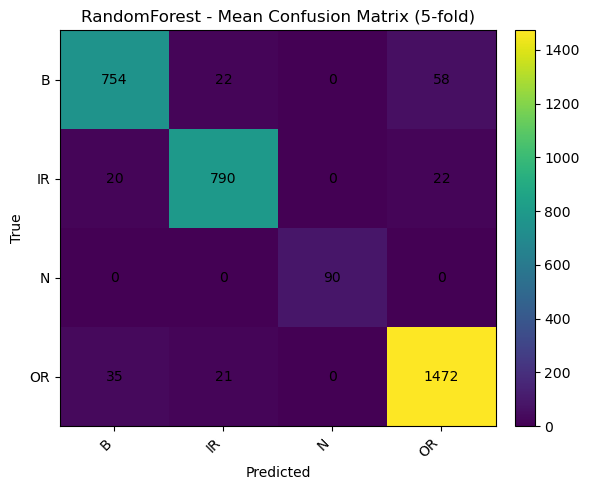

[RandomForest] CV-mean acc=0.9456 | macroF1=0.9544
Fold 1: acc=0.6518, macroF1=0.7175
Fold 2: acc=0.6437, macroF1=0.7090
Fold 3: acc=0.6502, macroF1=0.7184
Fold 4: acc=0.6410, macroF1=0.7064
Fold 5: acc=0.6435, macroF1=0.7079


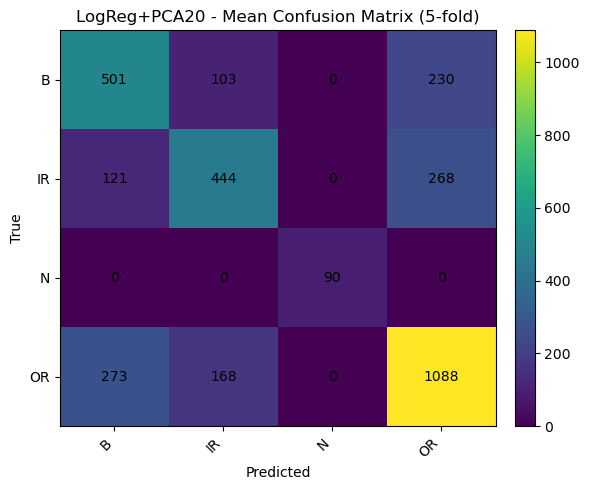

[LogReg+PCA20] CV-mean acc=0.6460 | macroF1=0.7118


,model,cv_acc,cv_macroF1
0,LightGBM,0.963161,0.969778
1,RandomForest,0.945564,0.954402
2,LogReg+PCA20,0.646045,0.711838


In [ ]:

models = []
if HAS_LGBM:
    models.append(("LightGBM", LGBMClassifier(
        objective="multiclass",
        num_class=len(set(y)),
        n_estimators=700,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42
    )))

models.append(("RandomForest", RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    class_weight={k:v for k,v in class_weight.items()},
    n_jobs=-1,
    random_state=42
)))

pipe = Pipeline(steps=[("scaler", StandardScaler()),
                      ("pca", PCA(n_components=20, random_state=42)),
                      ("clf", LogisticRegression(max_iter=3000, n_jobs=-1))])
models.append(("LogReg+PCA20", pipe))

leaderboard = []
for name, model in models:
    leaderboard.append(run_one_model(name, model, oversample=False))

df_scores = pd.DataFrame(leaderboard, columns=["model","cv_acc","cv_macroF1"]).sort_values("cv_macroF1", ascending=False)
df_scores.to_csv(OUT_DIR/"cv_scores.csv", index=False)
df_scores


In [ ]:
import joblib, json

best_model = LGBMClassifier(
    objective="multiclass",
    num_class=len(set(y)),
    n_estimators=700,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42
)
best_model.fit(X, y, sample_weight=sample_weight_all)

ARTI_DIR = Path("../data/3artifacts"); ARTI_DIR.mkdir(exist_ok=True)

json.dump(feat_cols, open(ARTI_DIR/"feat_cols.json","w"))

scaler = StandardScaler().fit(X)
joblib.dump(scaler, ARTI_DIR/"scaler.pkl")

joblib.dump(best_model, ARTI_DIR/"model.pkl")

classes = list(best_model.classes_)
json.dump(classes, open(ARTI_DIR/"classes.json","w"))

print("✅ artifacts 已导出到", ARTI_DIR)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6854
[LightGBM] [Info] Number of data points in the train set: 16423, number of used features: 28
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p